In [1]:
#########################
#########  
######### 
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'xlims' : (10., 3300.),
        'ylims' : (10e-1, 10e4),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'xlims' : (10., 4000.),
        'ylims' : (10e-1, 10e4),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'xlims' : (10., 1800.),
        'ylims' : (10e-1, 10e4),
        'name' : 'North East Sea'
    }
}

In [17]:
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


## Function to crop the dataset

def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None, alpha=0.85, 
              htype='bar', label=None, normed=None, lw=None):
    """
        Histogram is a function that helps to make a semi-log histogram plot
        of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
        The function accepts a dataset with any kind of values and it filters the
        nan values.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        n_bins : integer
            Number of bins for the histogram.
            
        xlims : tuple, float
            The limits for the x axis
        
        ylims : tuple, float
            The limits for the y axis
        
        i : integer
            Is the time step we adre working on. if None, it returns the
            complete array's histogram
            
        ax : axes.Axes object or array of Axes objects
            axes of the n-th sub plot
        
        Output:
        -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    ax.hist(a2, n_bins, range=ran, histtype=htype, label=label, alpha=alpha, 
            normed=normed, linewidth=lw)
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('# of occuped grid points', fontsize=10)
    ax.grid(True)
    
    
    
def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [4]:
dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'


c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')

c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
c_armor15 = Masking(c_armor15, c_armor15.to[0,25])

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason

## Limits for the regions

In [5]:
reg_g1 = Crops('gul', c_armor1)
reg_g15 = Crops('gul', c_armor15)
reg_g15 = Masking(reg_g15, reg_g15.to[0,25])

reg_l1 = Crops('lab', c_armor1)
reg_l15 = Crops('lab', c_armor15)
reg_l15 = Masking(reg_l15, reg_l15.to[0,25])

reg_n1 = Crops('noe', c_armor1)
reg_n15 = Crops('noe', c_armor15)
reg_n15 = Masking(reg_n15, reg_n15.to[0,25])

In [6]:
reg_l1.mlotst.where(reg_l15.mask==1)

<xarray.DataArray (time: 729, latitude: 60, longitude: 120)>
dask.array<shape=(729, 60, 120), dtype=float64, chunksize=(52, 60, 120)>
Coordinates:
  * longitude  (longitude) float32 -59.875 -59.625 -59.375 ... -30.375 -30.125
  * latitude   (latitude) float32 50.125 50.375 50.625 ... 64.375 64.625 64.875
  * time       (time) datetime64[ns] 2005-01-01 2005-01-08 ... 2018-12-15
    mask       (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    long_name:      Optimal mixed layer depth
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_theta_and_si...
    unit_long:      meter
    units:          m

## just for weekly

In [7]:
## Montnly average

avg_g = reg_g1.groupby('time.week').mean(dim='time')
avg_l = reg_l1.groupby('time.week').mean(dim='time')
avg_n = reg_n1.groupby('time.week').mean(dim='time')

avg_g.week

<xarray.DataArray 'week' (week: 53)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])
Coordinates:
  * week     (week) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53

In [8]:
## Making time dimensions as timestamps

d1 = datetime.datetime(2000,1,1)
d2 = datetime.datetime(2000,12,31)

week2 = pd.date_range(start=d1, end=d2, freq='7D')
avg_g.coords['time'] = (('time'), week2)
avg_l.coords['time'] = (('time'), week2)
avg_n.coords['time'] = (('time'), week2)

In [24]:
week = np.arange(0, 53, 8)
avg_g.mlotst[1].where(reg_g15.mask==1)
print(week)

[ 0  8 16 24 32 40 48]


### Gulf Stream

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


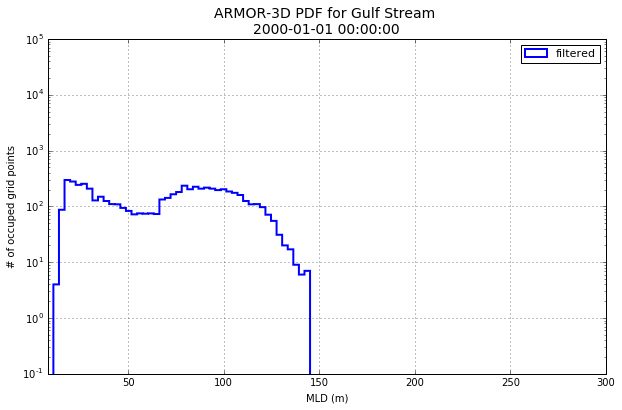

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


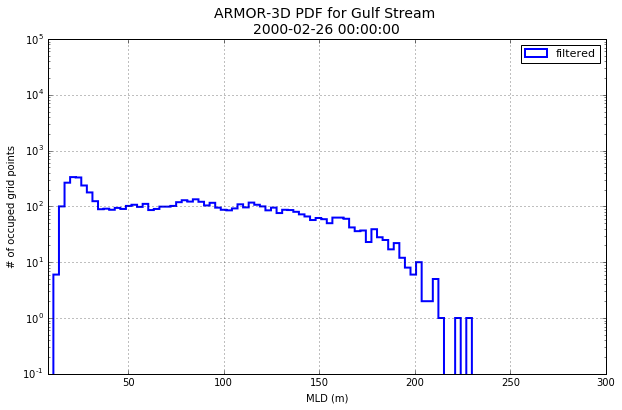

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


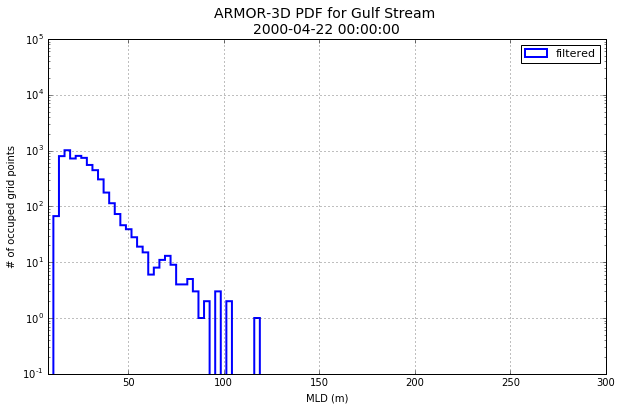

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


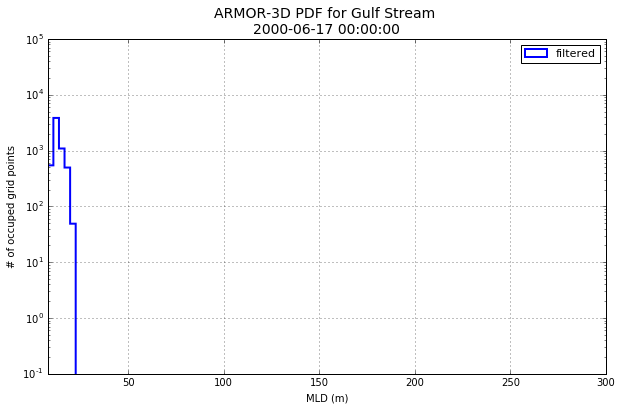

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


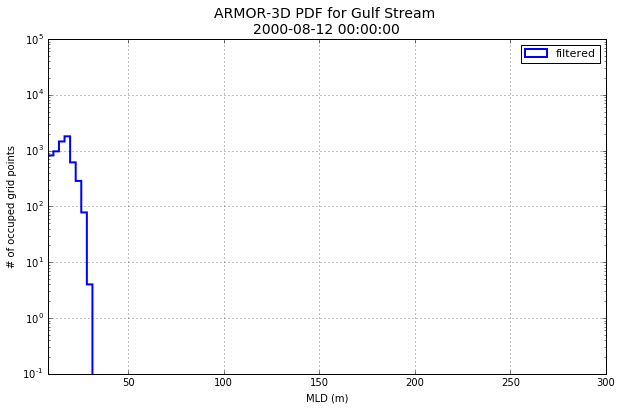

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


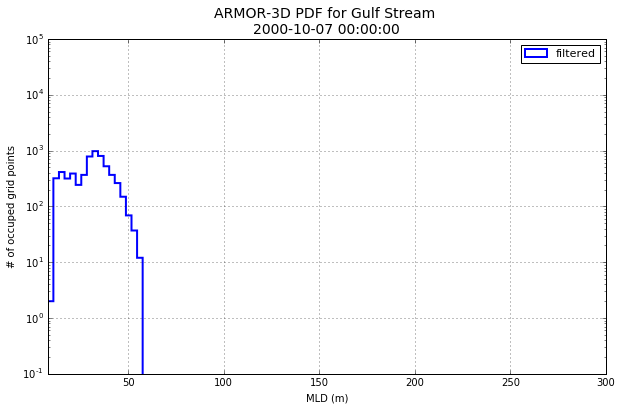

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


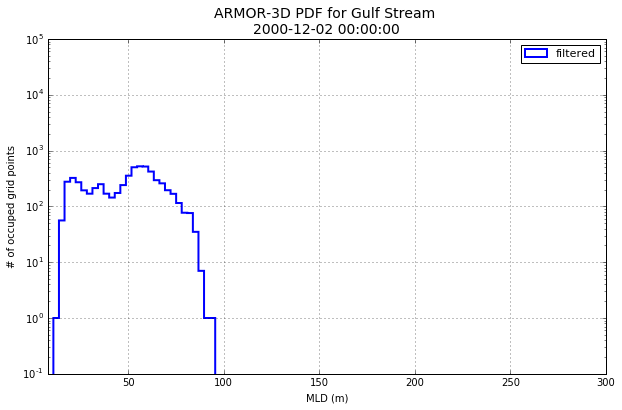

In [26]:
for m in week:
    var2 = avg_g.mlotst[m].where(reg_g15.mask==1)

    xlim_g = 8., 300.
    ylim_g = 10e-2, 10e4
    
    tit = str(pd.to_datetime(avg_g.time.values[m]))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)
    
    Histogram(var2, 100, xlim_g, ylim_g, None, ax, 1., 'step', 
          'filtered', lw=2)
    #Histogram(var2, 100, xlim_g, ylim_g, i=None, ax=ax, alpha=1., htype='step')#, 
    #          #label=None, normed=True, lw=2.)
    
    ax.set_title('ARMOR-3D PDF for Gulf Stream \n' + tit, fontsize=14)

    plt.legend(fontsize=11)
    plt.savefig(dir_o + 'Gul-PDF-' + str(m) + '.png')
    plt.show()

In [13]:
for m in week:
    var2 = avg_l.mlotst[m].where(avg_l.mask==1)

    xlim_g = 8., avg_l.mlotst.max(skipna=True).values + 15.
    ylim_g = 10e-2, 10e4
    tit = str(m)


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)

    #Histogram(var1, 100, xlim_g, ylim_g, None, ax, 1., 'step', 
    #          'complete', lw=2)

    Histogram(var2, 100, xlim_g, ylim_g, None, ax, 1., 'step', 
              'filtered', lw=2)
    ax.set_title('ARMOR-3D PDF for Labrador and Irminger Seas \n' + tit, fontsize=14)

    plt.legend(fontsize=11)
    
    #plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-PDF-' + tit + '.png')
    plt.show()

AttributeError: 'Dataset' object has no attribute 'mask'

In [ ]:
for m in week:
    #var1 = avg_n.mlotst[m]
    var2 = avg_n.mlotst[m].where(avg_n.mask==1)

    xlim_g = 8., avg_n.mlotst.max(skipna=True).values + 15.
    ylim_g = 10e-2, 10e4
    tit = str(m)


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)

    #Histogram(var1, 100, xlim_g, ylim_g, None, ax, 1., 'step', 
    #          'complete', lw=2)

    Histogram(var2, 100, xlim_g, ylim_g, None, ax, 1., 'step', 
              'filtered', lw=2)
    ax.set_title('ARMOR-3D PDF for North East \n' + tit, fontsize=14)

    plt.legend(fontsize=11)
    #plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-PDF-' + str(m) + '.png')
    plt.show()

## Animations for PDF in time


Here I try to make the animation, changing x-limits for summer/winter time. Also using both dataset: the filtered and the complete one.

In [ ]:
### Function to create all the figures to make the animation 
### histogram/time. It plots a small zoomed area in the histogram
### for the summer/autum time, i.e. June-November, that allows 
### to see more details of the distribution if the grid points.


import os
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.use('Agg')

N = int(reg.time.size)

print(N)

def generate_one_figure(it=1):
    print(it)

    dir_1 = '/home/lgarcia/Documents/data_ARMOR/'
    fl_n1 = 'ARMOR_*.nc'
    c_armor = xr.open_mfdataset(dir_1 + fl_n1)
    
    list_month = [6, 7, 8, 9, 10, 11]
    
    coord = 'noe'
    reg = Crops(coord, c_armor)
    
    time = pandas.to_datetime(reg.time[it].values)
    month = time.month

    reg = Masking(reg, reg.to[0,25])
    ds = reg.where(reg.mask == 1)

    n_bins = 100
    
    if month in list_month:
        xlim = 9., 300.
        ylim = 10e-1, 10e4
        tit = 'SUMMER'
    else:
        xlim = reg_ext[coord]['xlims']
        ylim = 10e-1, 10e4
        tit = 'WINTER'

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 9), 
                           sharey=True)
    
    Histogram(ds.mlotst, n_bins, xlim, ylim, it, ax[0])
    ax[0].set_xlabel('MLD [m]')
    ax[0].set_ylabel('# of occuped grid points')
    ax[0].set_title('MLD using h>2000m', fontsize=11)
    
    Histogram(reg.mlotst, n_bins, xlim, ylim, it, ax[1])
    ax[1].set_xlabel('MLD [m]')
    ax[1].set_ylabel('# of occuped grid points')
    ax[1].set_title('MLD, all h',  fontsize=11)
    
    plt.suptitle('Week %s :: %s' % (time, tit), fontsize=14)
    
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.9, wspace=0.25, hspace=0.3)

    plt.savefig(os.path.abspath(os.path.sep.join([".","../../dummy_images","NOE_PDF_WM_%0.4d.png" % it])))
    plt.close()
    return None



print('Use %i processes' % multiprocessing.cpu_count() ) 

with multiprocessing.Pool() as pool:
    pool.map( generate_one_figure, np.arange(0,400)) 
    
with multiprocessing.Pool() as pool:
    pool.map( generate_one_figure, np.arange(400,730))  
    
print('finish!')  



In [ ]:
## mencoder "mf://dummy_images/Gul_*.png" -mf fps=10 -o Gulf.avi -ovc lavc -lavcopts 
## vcodec=msmpeg4v2:vbitrate=2500

## ffmpeg -r 1.5 -f image2 -s 1920x1080 -i dummy_images/NOE_PDF_H2000_%04d.png -vcodec libx264 -crf 25  
## -pix_fmt yuv420p -q:v 1 Animations/NOE_PDF_H2000.mp4